In [16]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Data Loading

In [17]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf, ccf
from scipy.stats import wasserstein_distance, ks_2samp, skew, kurtosis

import scienceplots
# plt.style.use('science')
plt.style.use(["science", "high-vis"])

In [174]:
all_samples = {
    "Historical": pd.read_csv("dataloaders/data/ercot.csv"),
    "FVARMA": pd.read_csv("ercot_samples_varma.csv"),
    "CNN-GAN": pd.read_csv("saved_models/cnn_best_wind/ercot_samples_cnn.csv"),
    "DGAN": pd.read_csv("saved_models/best_dgan/synthetic.csv"),
    "NSDE": pd.read_csv("ercot_samples_sde_time_indep_swa.csv")
}
varnames_original = ["TOTALLOAD", "WIND", "SOLAR"]
all_samples["FVARMA"] = all_samples["FVARMA"][varnames_original]
varnames = ["Electricity Demand (MWh)", "Wind Power (MWh)", "Solar Power (MWh)"]
for k, v in all_samples.items():
    samples = v[varnames_original].values.reshape(-1, 24, len(varnames))
    all_samples[k] = samples

In [100]:
plots_dir = "plots/journal"
os.makedirs(plots_dir, exist_ok=True)

COLORS = ["#1f77b4", "#2ca02c", "#ff7f0e", "#d62728", "#9467bd", "#8c564b"]

# The Historical Data

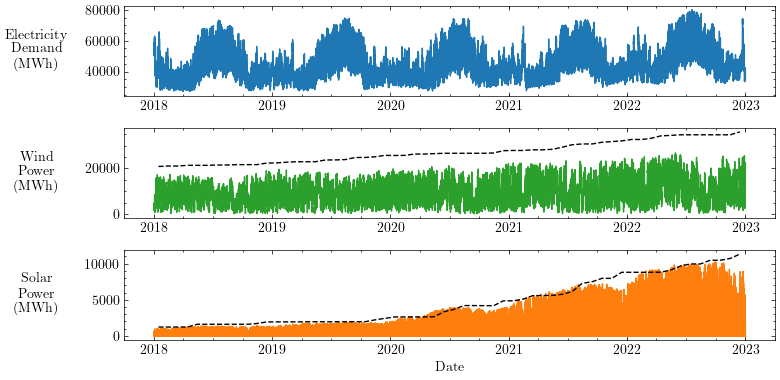

Year 2022 - Mean: 49073.591773469176, Std: 10502.989133706267


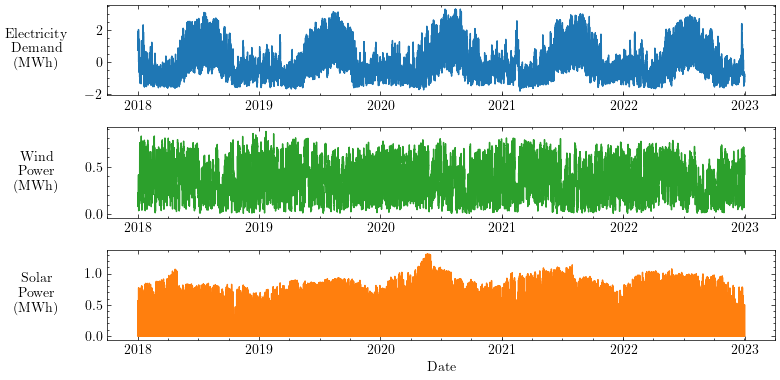

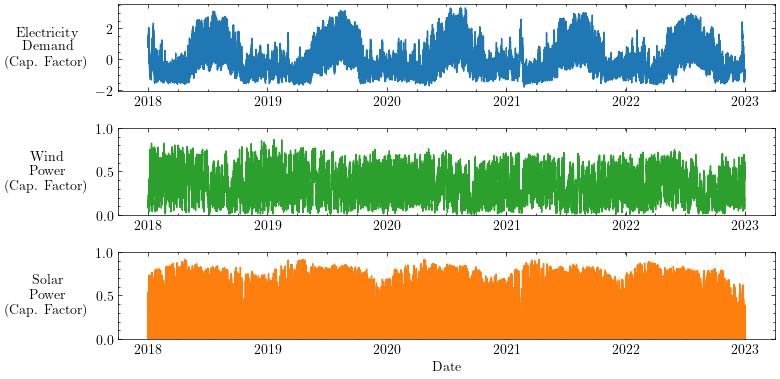

In [180]:
# Plot the original historical data as well as the scaled versions of the historical data used for training the models.
dates = pd.date_range(start="2018-01-01 00:00", periods=len(all_samples["Historical"][..., 0].ravel()), freq="H")

# Original data
original_data = pd.read_csv("dataloaders/data/ercot_raw.csv")[varnames_original].values.reshape(-1, 24, len(varnames))
monthly_caps = pd.read_csv("dataloaders/data/monthly_context.csv")[["WIND", "SOLAR"]]
monthly_caps.index = pd.date_range(start="2017-12-01", periods=len(monthly_caps), freq="M") + pd.Timedelta(days=15)
fig, ax = plt.subplots(3, 1, figsize=(8, 4))
for idx, varname in enumerate(varnames):
    var_samples = original_data[..., idx].ravel()
    varname = varname.replace(" ", "\n")
    ax[idx].plot(dates, var_samples, label="Historical", color=COLORS[idx])
    if "Wind" in varname:
        ax[idx].plot(monthly_caps["WIND"], color="black", linestyle="--")
    if "Solar" in varname:
        ax[idx].plot(monthly_caps["SOLAR"], color="black", linestyle="--")
    ax[idx].set_ylabel(varname, rotation=0, labelpad=35, va="center")
    if idx == 2:
        ax[idx].set_xlabel("Date")
fig.tight_layout()
fig.savefig(f"{plots_dir}/historical_data.pdf", dpi=300)
plt.show()
plt.close(fig)

# Original data
fig, ax = plt.subplots(3, 1, figsize=(8, 4))
# Cast the monthly capacities to the same shape as the historical data by repeating the values for
# each hour in the month.
# monthly_caps.index = pd.date_range(start="2017-12-01", periods=60, freq="M") + pd.Timedelta(days=1)
hourly_caps = []
for i, month in enumerate(pd.date_range(start="2018-01-01", periods=60, freq="M")):
    hourly_caps.append(pd.DataFrame({
        "WIND": np.repeat(monthly_caps["WIND"].iloc[i], month.days_in_month * 24),
        "SOLAR": np.repeat(monthly_caps["SOLAR"].iloc[i], month.days_in_month * 24)
    }))
hourly_caps = pd.concat(hourly_caps)
hourly_caps.index = pd.date_range(start="2018-01-01 00:00", periods=len(hourly_caps), freq="H")

ercot_eia = pd.read_csv("dataloaders/data/ercot_raw.csv")
ercot_eia.index = pd.date_range(start="2018-01-01 00:00", periods=len(ercot_eia), freq="H")
ercot_eia["WIND"] = ercot_eia["WIND"] / hourly_caps["WIND"]
ercot_eia["SOLAR"] = ercot_eia["SOLAR"] / hourly_caps["SOLAR"]
for year in range(2018, 2023):
    year_mask = (ercot_eia.index.year == year)
    if year == 2022:
        year_vals = ercot_eia.loc[year_mask, "TOTALLOAD"].values
        print(f"Year {year} - Mean: {year_vals.mean()}, Std: {year_vals.std()}")
    ercot_eia.loc[year_mask, "TOTALLOAD"] = (ercot_eia.loc[year_mask, "TOTALLOAD"] - ercot_eia.loc[year_mask, "TOTALLOAD"].mean()) / ercot_eia.loc[year_mask, "TOTALLOAD"].std()
ercot_eia.to_csv("dataloaders/data/ercot_eia.csv", index=False)
scaled_data = ercot_eia[varnames_original].values.reshape(-1, 24, len(varnames))

for idx, varname in enumerate(varnames):
    var_samples = scaled_data[..., idx].ravel()
    varname = varname.replace(" ", "\n")
    ax[idx].plot(dates, var_samples, color=COLORS[idx])
    ax[idx].set_ylabel(varname, rotation=0, labelpad=35, va="center")
    if idx == 2:
        ax[idx].set_xlabel("Date")
fig.tight_layout()
fig.savefig(f"{plots_dir}/scaled_historical_data_alt.pdf", dpi=300)
plt.show()
plt.close(fig)

# Scaled historical data
fig, ax = plt.subplots(3, 1, figsize=(8, 4))
for idx, varname in enumerate(varnames):
    var_samples = all_samples["Historical"][..., idx].ravel()
    if "Electricity Demand" in varname:
        # Apply a standard scaler to the electricity demand data on a yearly basis.
        for year in range(2018, 2023):
            year_mask = (dates.year == year)
            var_samples[year_mask] = (var_samples[year_mask] - var_samples[year_mask].mean()) / var_samples[year_mask].std()
    varname = varname.replace(" ", "\n")
    unit_str = "(GWh)" if "(GWh)" in varname else "(MWh)"
    norm_str = "(Normalized)" if "Electricity Demand" in varname else "(Cap. Factor)"
    varname = varname.replace(unit_str, norm_str)
    ax[idx].plot(dates, var_samples, color=COLORS[idx])
    ax[idx].set_ylabel(varname, rotation=0, labelpad=35, va="center")
    if idx == 2:
        ax[idx].set_xlabel("Date")
    if idx >= 1:
        ax[idx].set_ylim([0, 1])
fig.tight_layout()
fig.savefig(f"{plots_dir}/scaled_historical_data.pdf", dpi=300)
plt.show()
plt.close(fig)

# Basic Statistics

In [61]:
stats_summary = {}

for i, var in enumerate(varnames):
    header = f"{'Variable':10}{'Method':10}{'Mean':>10}{'Std':>10}{'Skewness':>10}{'Kurtosis':>10}{'Min':>10}{'Max':>10}{'P05':>10}{'P95':>10}{'WD':>10}{'KS2S':>10}"
    print(header)
    for di, (k, v) in enumerate(all_samples.items()):
        stats_summary[(var, k)] = {
            "mean": np.mean(v[..., i].ravel()),
            "std": np.std(v[..., i].ravel()),
            "skewness": skew(v[..., i].ravel()),
            "kurtosis": kurtosis(v[..., i].ravel()),
            "min": np.min(v[..., i].ravel()),
            "max": np.max(v[..., i].ravel()),
            "P05": np.percentile(v[..., i].ravel(), 5),
            "P95": np.percentile(v[..., i].ravel(), 95),
            "WD": wasserstein_distance(all_samples["Historical"][..., i].ravel(), v[..., i].ravel()),
            "KS2S": ks_2samp(all_samples["Historical"][..., i].ravel(), v[..., i].ravel(), method="asymp")[0]
        }
        table_line = f"{var:10}{k:10}"
        for name, val in stats_summary[(var, k)].items():
            table_line += f"{val:10.3f}"
        print(table_line)
    print()

Variable  Method          Mean       Std  Skewness  Kurtosis       Min       Max       P05       P95        WD      KS2S
TOTALLOAD Historical    49.345    11.031     0.933     0.262    29.478    88.107    35.215    72.239     0.000     0.000
TOTALLOAD FVARMA        49.327    11.055     0.922     0.265    28.171    90.074    35.273    72.144     0.082     0.007
TOTALLOAD CNN-GAN       49.593    10.827     0.947     0.229    28.552    90.033    36.027    72.075     0.292     0.019
TOTALLOAD DGAN          49.713    11.493     0.904     0.106    30.253    87.250    35.391    73.431     0.491     0.021
TOTALLOAD NSDE          49.850    11.251     0.897     0.095    28.396    90.510    35.313    73.057     0.511     0.019

Variable  Method          Mean       Std  Skewness  Kurtosis       Min       Max       P05       P95        WD      KS2S
WIND      Historical     0.353     0.186     0.144    -1.031     0.004     0.867     0.073     0.654     0.000     0.000
WIND      FVARMA         0.354 

As expected, the 2-sample KS test concludes that the generated series are from a different distribution (with the exception of FVARMA for TOTALLOAD).
This is the expected result because the power of the 2-sample KS test increases with the number of samples, meaning that when many samples are used, the test can detect even small differences in the CDF of the two samples.

The Kolmogorov-Smirnov statistic is
$$D_{n,m} = \sup_x \left|F_{1,n}(x) - F_{2,m}(x)\right|$$
and the null hypothesis is rejected at the $\alpha$ level if
$$D_{n,m} > c(\alpha) \sqrt{\frac{n+m}{n \cdot m}}.$$
With $\alpha = 0.001$, $c(\alpha) = 1.949$.
The data we have has size $n = m = 43824$.
Therefore, the square root term is equal to 0.004777, and with $\alpha = 0.001$, the significant test statistic is 0.00931.
This is a *very* small minimum difference even at the 99.9% confidence level!

# Autocorrelation Plots

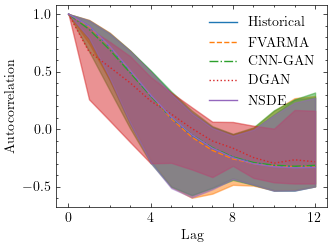

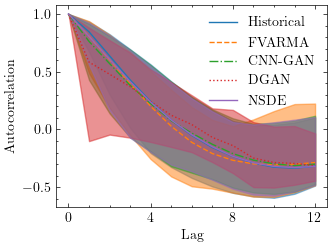

/Users/jacobbryan/miniforge3/envs/torch/lib/python3.11/site-packages/statsmodels/tsa/stattools.py:693: RuntimeWarning: invalid value encountered in divide
  acf = avf[: nlags + 1] / avf[0]


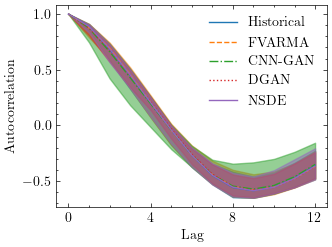

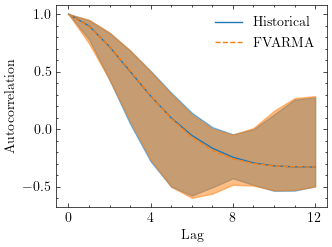

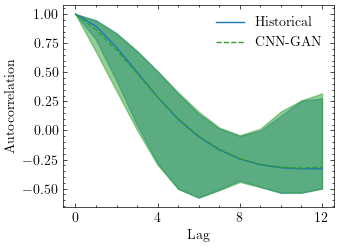

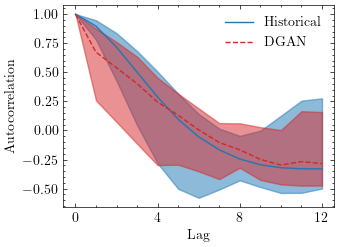

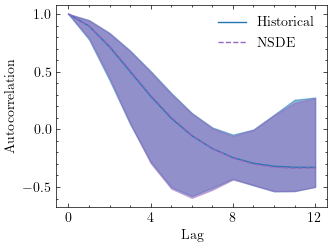

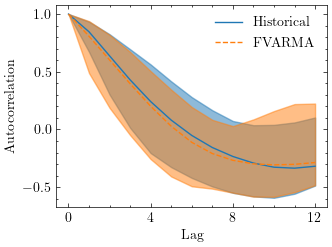

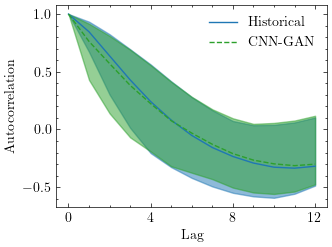

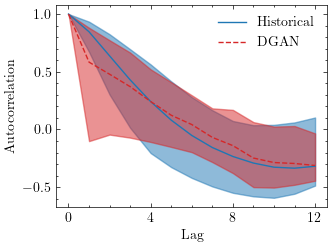

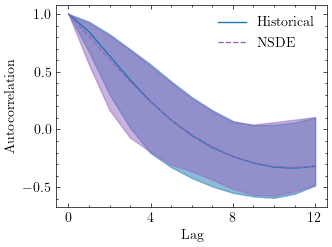

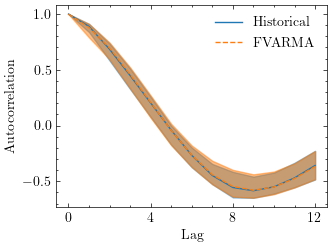

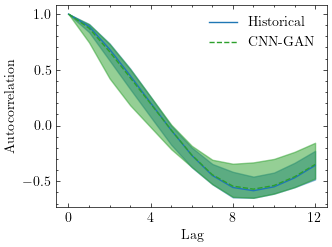

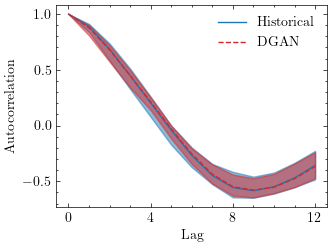

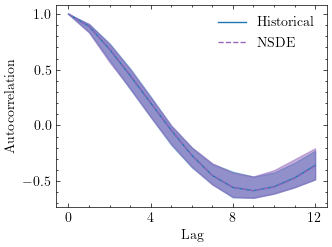

In [21]:
for i, var in enumerate(varnames):
    plt.figure()
    for di, (k, v) in enumerate(all_samples.items()):
        # if k not in ["Historical", "SDE-GAN"]:
        #     continue
        samples_acf = np.array([acf(v[j, :, i], nlags=12, fft=False) for j in range(v.shape[0])])
        # Drop any samples that have NaN values
        samples_acf = samples_acf[~np.isnan(samples_acf).any(axis=1)]
        acf_mean = samples_acf.mean(axis=0)
        acf_ci = np.percentile(samples_acf, [2.5, 97.5], axis=0)
        plt.plot(np.arange(13), acf_mean, label=k, color=COLORS[di])
        plt.fill_between(np.arange(13), acf_ci[0], acf_ci[1], alpha=0.5, color=COLORS[di])
    plt.xlabel("Lag")
    plt.ylabel("Autocorrelation")
    plt.xticks([0, 4, 8, 12])
    plt.legend()
    plt.savefig(os.path.join(plots_dir, f"acf_{var}.png"), dpi=300)
    plt.show()

for i, var in enumerate(varnames):
    plt.figure()
    v = all_samples["Historical"]
    acf_historical = np.array([acf(v[j, :, i], nlags=12, fft=False) for j in range(v.shape[0])])
    acf_mean_historical = acf_historical.mean(axis=0)
    acf_ci_historical = np.percentile(acf_historical, [2.5, 97.5], axis=0)

    for di, (k, v) in enumerate(all_samples.items()):
        if k == "Historical":
            continue
        samples_acf = np.array([acf(v[j, :, i], nlags=12, fft=False) for j in range(v.shape[0])])
        # Drop any samples that have NaN values
        samples_acf = samples_acf[~np.isnan(samples_acf).any(axis=1)]
        acf_mean = samples_acf.mean(axis=0)
        acf_ci = np.percentile(samples_acf, [2.5, 97.5], axis=0)
        plt.plot(np.arange(13), acf_mean_historical, label="Historical", color=COLORS[0])
        plt.fill_between(np.arange(13), acf_ci_historical[0], acf_ci_historical[1], alpha=0.5, color=COLORS[0])
        plt.plot(np.arange(13), acf_mean, label=k, color=COLORS[di])
        plt.fill_between(np.arange(13), acf_ci[0], acf_ci[1], alpha=0.5, color=COLORS[di])
        plt.xlabel("Lag")
        plt.ylabel("Autocorrelation")
        plt.xticks([0, 4, 8, 12])
        plt.legend()
        plt.savefig(os.path.join(plots_dir, f"acf_{var}_{k}.png"), dpi=300)
        plt.show()

# Cross-Correlation Plots

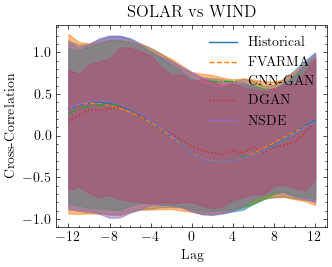

/Users/jacobbryan/miniforge3/envs/torch/lib/python3.11/site-packages/statsmodels/tsa/stattools.py:1168: RuntimeWarning: invalid value encountered in divide
  ret = cvf / (np.std(x) * np.std(y))


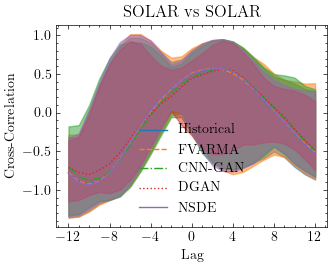

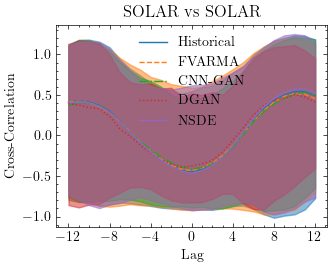

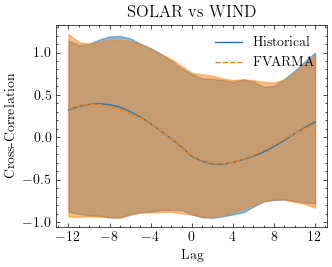

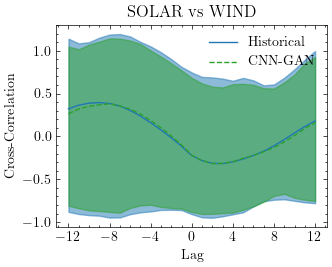

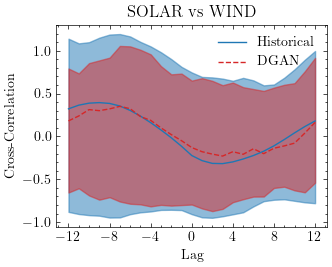

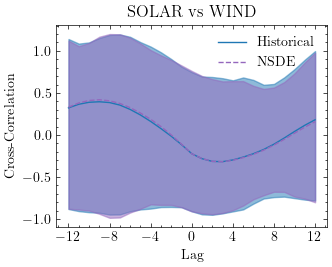

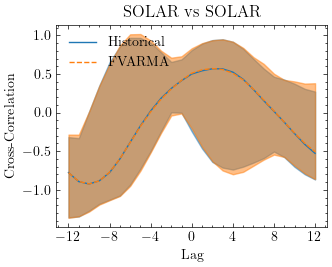

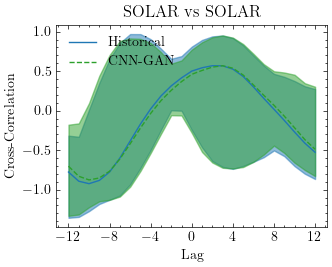

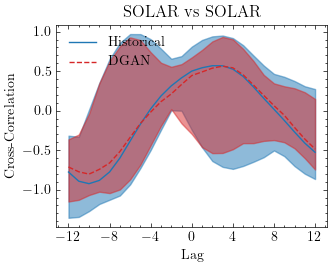

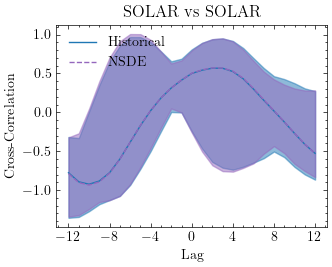

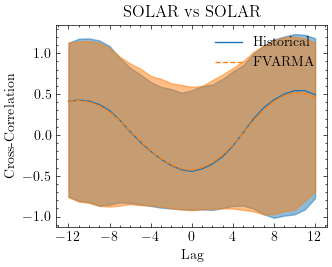

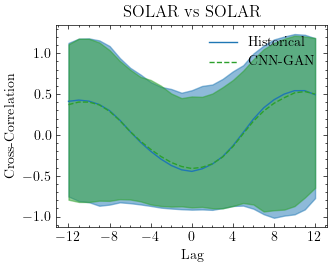

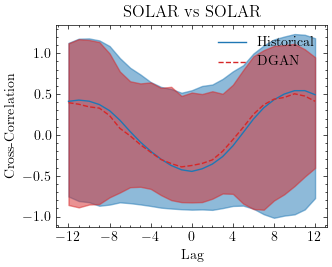

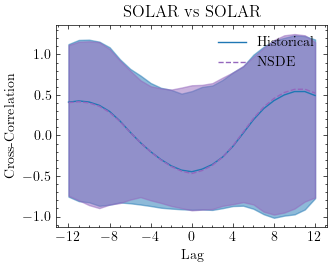

In [22]:
for idx_var1, var1 in enumerate(varnames):
    for idx_var2, var2 in enumerate(varnames):
        if idx_var1 >= idx_var2:
            continue
        plt.figure()
        for idx_model, (k, v) in enumerate(all_samples.items()):
            backwards = np.array([ccf(v[i, :, idx_var1][::-1], v[i, :, idx_var2][::-1], nlags=13, fft=False)[::-1] for i in range(v.shape[0])])
            forwards  = np.array([ccf(v[i, :, idx_var1],       v[i, :, idx_var2],       nlags=13, fft=False)       for i in range(v.shape[0])])
            xcf = np.concatenate([backwards[:, :-1], forwards], axis=1)
            # drop any samples that have NaN values
            xcf = xcf[~np.isnan(xcf).any(axis=1)]
            plt.plot(np.arange(-12, 13), xcf.mean(axis=0), label=k, color=COLORS[idx_model])
            plt.fill_between(np.arange(-12, 13), np.percentile(xcf, 2.5, axis=0), np.percentile(xcf, 97.5, axis=0), alpha=0.5, color=COLORS[idx_model])
        plt.xlabel("Lag")
        plt.ylabel("Cross-Correlation")
        plt.xticks([-12, -8, -4, 0, 4, 8, 12])
        plt.title(f"{var} vs {var2}")
        plt.legend()
        plt.savefig(os.path.join(plots_dir, f"ccf_{var}_{var2}.png"), dpi=300)
        plt.show()

for idx_var1, var1 in enumerate(varnames):
    for idx_var2, var2 in enumerate(varnames):
        if idx_var1 >= idx_var2:
            continue
        plt.figure()
        v = all_samples["Historical"]
        backwards = np.array([ccf(v[i, :, idx_var1][::-1], v[i, :, idx_var2][::-1], nlags=13, fft=False)[::-1] for i in range(v.shape[0])])
        forwards  = np.array([ccf(v[i, :, idx_var1],       v[i, :, idx_var2],       nlags=13, fft=False)       for i in range(v.shape[0])])
        xcf_historical = np.concatenate([backwards[:, :-1], forwards], axis=1)
        # drop any samples that have NaN values
        xcf_historical = xcf_historical[~np.isnan(xcf_historical).any(axis=1)]
        for idx_model, (k, v) in enumerate(all_samples.items()):
            if k == "Historical":
                continue
            backwards = np.array([ccf(v[i, :, idx_var1][::-1], v[i, :, idx_var2][::-1], nlags=13, fft=False)[::-1] for i in range(v.shape[0])])
            forwards  = np.array([ccf(v[i, :, idx_var1],       v[i, :, idx_var2],       nlags=13, fft=False)       for i in range(v.shape[0])])
            xcf = np.concatenate([backwards[:, :-1], forwards], axis=1)
            # drop any samples that have NaN values
            xcf = xcf[~np.isnan(xcf).any(axis=1)]
            plt.plot(np.arange(-12, 13), xcf_historical.mean(axis=0), label="Historical", color=COLORS[0])
            plt.fill_between(np.arange(-12, 13), np.percentile(xcf_historical, 2.5, axis=0), np.percentile(xcf_historical, 97.5, axis=0), alpha=0.5, color=COLORS[0])
            plt.plot(np.arange(-12, 13), xcf.mean(axis=0), label=k, color=COLORS[idx_model])
            plt.fill_between(np.arange(-12, 13), np.percentile(xcf, 2.5, axis=0), np.percentile(xcf, 97.5, axis=0), alpha=0.5, color=COLORS[idx_model])
            plt.xlabel("Lag")
            plt.ylabel("Cross-Correlation")
            plt.xticks([-12, -8, -4, 0, 4, 8, 12])
            plt.title(f"{var} vs {var2}")
            plt.legend()
            plt.savefig(os.path.join(plots_dir, f"ccf_{var}_{var2}_{k}.png"), dpi=300)
            plt.show()

# Distribution Plots

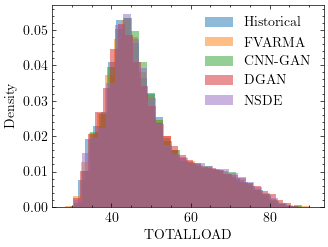

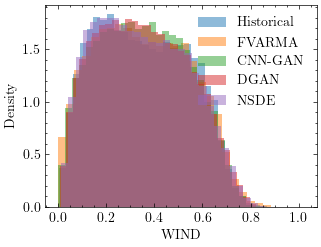

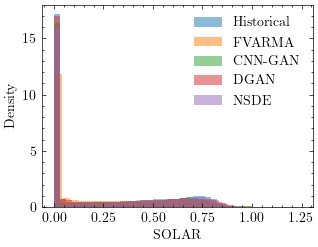

In [23]:
for i, var in enumerate(varnames):
    plt.figure()
    for di, (k, v) in enumerate(all_samples.items()):
        samples = v[..., i].ravel()
        plt.hist(samples, bins=30, alpha=0.5, label=k, color=COLORS[di], density=True)
    plt.xlabel(var)
    plt.ylabel("Density")
    plt.legend()
    plt.show()

# CDF Plots

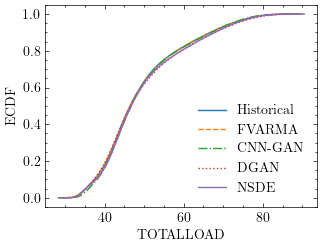

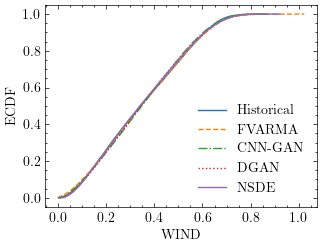

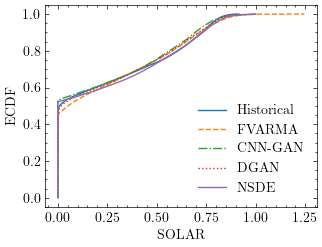

In [29]:
for i, var in enumerate(varnames):
    plt.figure()
    for di, (k, v) in enumerate(all_samples.items()):
        samples = v[..., i].ravel()
        samples_sorted = np.sort(samples)
        ecdf = np.linspace(0, 1, len(samples_sorted))
        plt.plot(samples_sorted, ecdf, label=k, color=COLORS[di])
    plt.xlabel(var)
    plt.ylabel("ECDF")
    plt.legend()
    plt.savefig(os.path.join(plots_dir, f"ecdf_{var}.png"), dpi=300)
    plt.show()

# Q-Q Plots

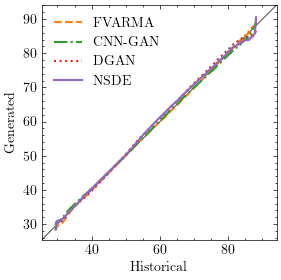

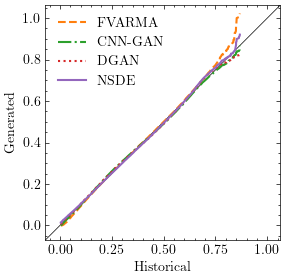

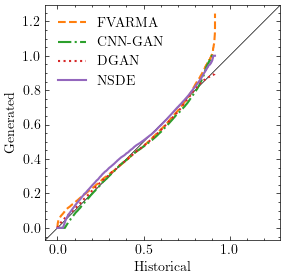

In [71]:
linestyles = ["--", "-.", ":", "-"]
for i, var in enumerate(varnames):
    plt.figure(figsize=(5, 3))
    vmin = np.min([min(v[..., i].ravel()) for v in all_samples.values()])
    vmax = np.max([max(v[..., i].ravel()) for v in all_samples.values()])
    vmin_lim = vmin - max(np.abs(vmin * 0.1), 0.07)
    vmax_lim = vmax + np.abs(vmax * 0.04)
    plt.xlim([vmin_lim, vmax_lim])
    plt.ylim([vmin_lim, vmax_lim])
    plt.plot([vmin_lim, vmax_lim], [vmin_lim, vmax_lim], color="black", linestyle="-", linewidth=0.5)
    historical_samples = all_samples["Historical"][..., i].ravel()
    historical_samples_sorted = np.sort(historical_samples)
    historical_ecdf = np.linspace(0, 1, len(historical_samples_sorted))
    for di, (k, v) in enumerate(all_samples.items()):
        if k == "Historical":
            continue
        samples = v[..., i].ravel()
        samples_sorted = np.sort(samples)
        ecdf = np.linspace(0, 1, len(samples_sorted))
        plt.plot(historical_samples_sorted, samples_sorted, label=k, color=COLORS[di], linestyle=linestyles[di-1], linewidth=1.5)
    plt.xlabel("Historical")
    plt.ylabel("Generated")
    plt.legend()
    plt.gca().set_aspect('equal', adjustable='box')
    plt.tight_layout()
    plt.savefig(os.path.join(plots_dir, f"qq_{var}.png"), dpi=300)
    plt.show()